<a href="https://colab.research.google.com/github/AnupPandey04/Taxi-Fare-Prediction/blob/main/Taxi_Fare_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")


Loading dataset "NYC TLC Yellow Taxi Trip Records for June 2024"
Source:- https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [ ]:
import pandas as pd
!pip install pyarrow
df = pd.read_parquet('/content/yellow_tripdata_2024-06.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-06-01 00:03:46,2024-06-01 00:31:23,1.0,12.50,1.0,N,138,195,1,48.5,7.75,0.5,11.55,0.0,1.0,69.30,0.0,1.75
1,2,2024-06-01 00:55:22,2024-06-01 01:08:24,1.0,4.34,1.0,N,138,7,1,20.5,6.00,0.5,8.40,0.0,1.0,38.15,0.0,1.75
2,1,2024-06-01 00:23:53,2024-06-01 00:32:35,1.0,1.30,1.0,N,166,41,1,10.0,1.00,0.5,3.10,0.0,1.0,15.60,0.0,0.00
3,1,2024-06-01 00:32:24,2024-06-01 00:40:06,1.0,1.20,1.0,N,148,114,1,8.6,3.50,0.5,0.20,0.0,1.0,13.80,2.5,0.00
4,1,2024-06-01 00:51:38,2024-06-01 00:58:17,1.0,1.00,1.0,N,148,249,1,7.2,3.50,0.5,2.00,0.0,1.0,14.20,2.5,0.00


Data Cleaning

In [ ]:
df = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
         'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
         'fare_amount', 'tip_amount', 'total_amount']]

df.dropna(inplace=True)
df = df[df['fare_amount'] > 0]
df = df[df['trip_distance'] > 0]
df.head()


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount
0,2024-06-01 00:03:46,2024-06-01 00:31:23,1.0,12.50,138,195,48.5,11.55,69.30
1,2024-06-01 00:55:22,2024-06-01 01:08:24,1.0,4.34,138,7,20.5,8.40,38.15
2,2024-06-01 00:23:53,2024-06-01 00:32:35,1.0,1.30,166,41,10.0,3.10,15.60
3,2024-06-01 00:32:24,2024-06-01 00:40:06,1.0,1.20,148,114,8.6,0.20,13.80
4,2024-06-01 00:51:38,2024-06-01 00:58:17,1.0,1.00,148,249,7.2,2.00,14.20


Exploratory Data Analysis (EDA)

Summary Statistics:
              tpep_pickup_datetime       tpep_dropoff_datetime  \
count                     3040798                     3040798   
mean   2024-06-15 19:30:34.402960  2024-06-15 19:48:23.251451   
min           2008-12-31 00:00:00         2008-12-31 23:01:42   
25%    2024-06-08 01:30:09.250000  2024-06-08 01:44:27.500000   
50%    2024-06-15 13:40:37.500000         2024-06-15 13:57:36   
75%           2024-06-23 04:08:42  2024-06-23 04:23:24.750000   
max           2026-06-26 23:53:12         2026-06-27 20:59:10   
std                           NaN                         NaN   

       passenger_count  trip_distance  PULocationID  DOLocationID  \
count     3.040798e+06   3.040798e+06  3.040798e+06  3.040798e+06   
mean      1.336725e+00   3.810157e+00  1.648077e+02  1.642015e+02   
min       0.000000e+00   1.000000e-02  1.000000e+00  1.000000e+00   
25%       1.000000e+00   1.040000e+00  1.320000e+02  1.140000e+02   
50%       1.000000e+00   1.750000e+00  1.620000e

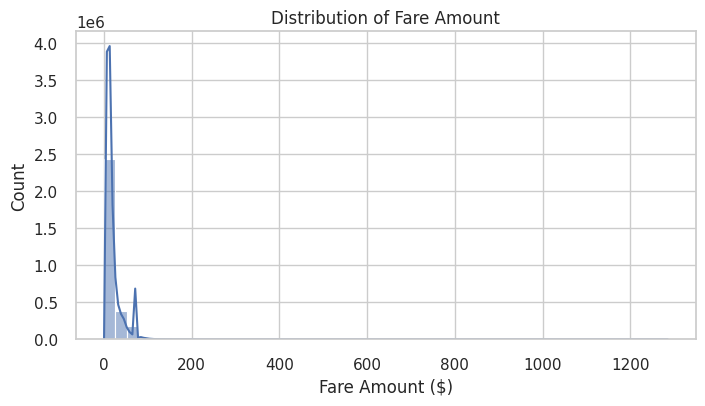

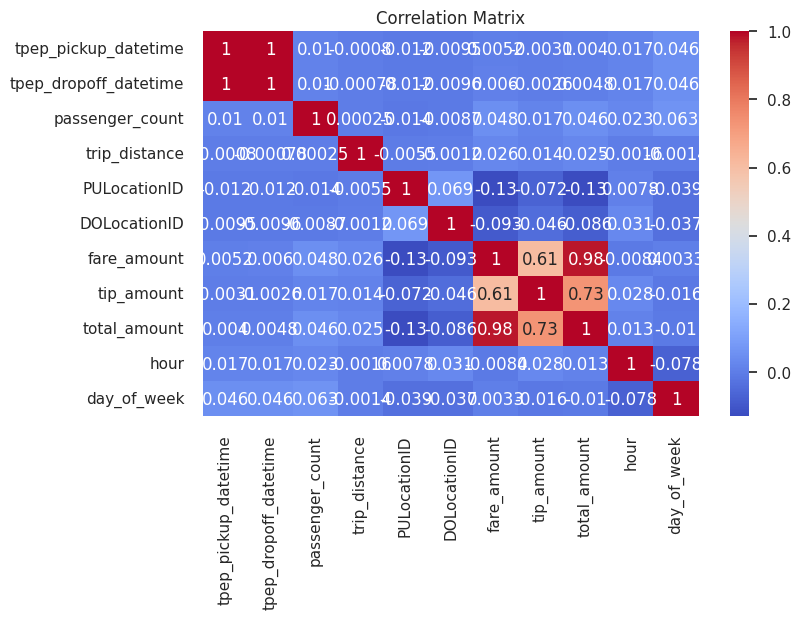

In [ ]:
print("Summary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())

# Histogram of Fare Amount
plt.figure(figsize=(8,4))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount ($)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Feature Engineering

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
features = ['trip_distance', 'passenger_count', 'hour', 'day_of_week']
target = 'fare_amount'

X = df[features]
y = df[target]

Simple Linear Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 12.075828174840442
MSE: 340.25726004680206
RMSE: 18.446063537969344
R² Score: 0.0024394619823793207


Visualizing Predictions

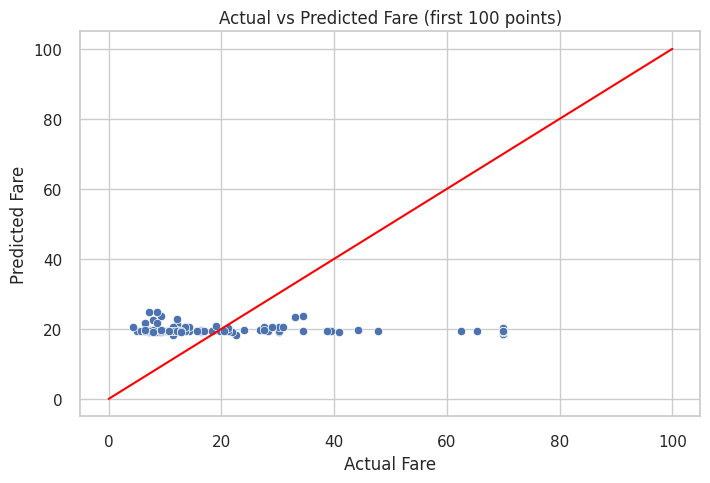

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test[:100].values, y=y_pred[:100])
plt.plot([0, 100], [0, 100], color='red')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Fare (first 100 points)")
plt.show()